# Импорт библиотек

In [1]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [2]:
batch_size = 1024
image_size = 128
in_channels = 3
z_dim = 100
generator_dim = 128
discriminator_dim = 128

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 2e-4
lr_g = lr
lr_d = lr

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [3]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# Загрузка данных

In [4]:
import torch
import torchvision
from torchvision import datasets, transforms

transform=transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

dataset_root = os.path.join(os.pardir, "celeba")
# Скачивание и загрузка датасета CelebA
dataset = datasets.ImageFolder(root=dataset_root, transform=transform)

# Создание DataLoader для итерации по датасету
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

Выведем примеры картинок из трейна

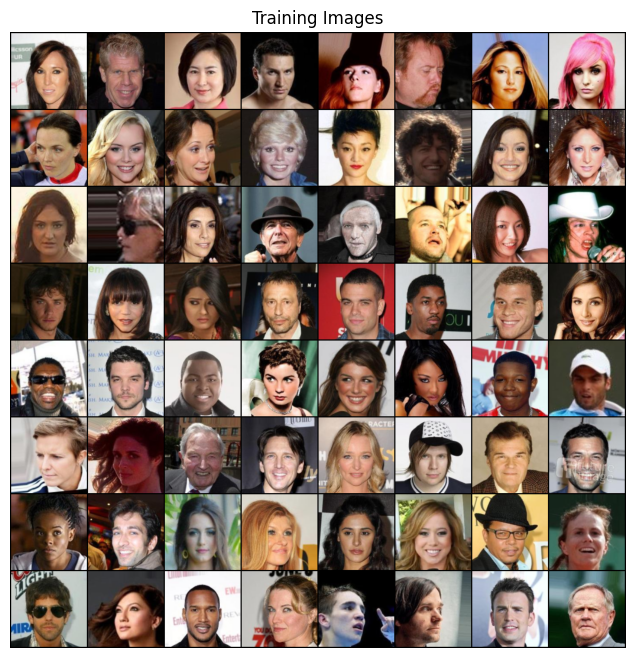

In [5]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [6]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [7]:
class CSPup(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.split_channels = in_channels // 2
        
        self.conv_path = nn.Sequential(
            nn.Conv2d(self.split_channels, self.split_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(self.split_channels),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(self.split_channels, self.split_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(self.split_channels),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(self.split_channels, self.split_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(self.split_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(self.split_channels, self.split_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(self.split_channels),
            nn.ReLU(inplace=True)
        )

        self.upsample_path = nn.Sequential(
            nn.ConvTranspose2d(self.split_channels, self.split_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(self.split_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x1, x2 = x.chunk(2, dim=1)
        
        conv_out = self.conv_path(x1)
        upsample_out = self.upsample_path(x2)
        
        out = conv_out + upsample_out
        return out

In [8]:
class Generator(nn.Module):
    def __init__(self, z_dim=100, img_channels=3):
        super(Generator, self).__init__()

        self.initial = nn.Sequential(
            nn.ConvTranspose2d(z_dim, 1024, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(True)
        )

        self.up1 = CSPup(1024, 512)
        self.up2 = CSPup(512, 256)
        self.up3 = CSPup(256, 128)
        self.up4 = CSPup(128, 64)

        self.final = nn.Sequential(
            nn.ConvTranspose2d(64, img_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        x = self.initial(z)
        x = self.up1(x)
        x = self.up2(x)
        x = self.up3(x)
        x = self.up4(x)
        image = self.final(x)
        return image

In [9]:
class Discriminator(nn.Module):
    def __init__(self, img_channels=3):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # Input: img_channels x 128 x 128
            nn.Conv2d(img_channels, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # State size: 64 x 64 x 64
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            # State size: 128 x 32 x 32
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            # State size: 256 x 16 x 16
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            # State size: 512 x 8 x 8
            nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True),

            # State size: 1024 x 4 x 4
            nn.Conv2d(1024, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.disc(input)

In [10]:
# Инициализируем генератор
netG = Generator().to(device)
netG.apply(weights_init)

netD = Discriminator().to(device)
netD.apply(weights_init)

Discriminator(
  (disc): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(1024, eps=1e-05

In [11]:
# Инициализируем лосс
criterion = nn.BCELoss()

# Создаем батч с рандомным шумом для генерации
fixed_noise = torch.randn(batch_size, z_dim, 1, 1, device=device)

# Метки для реальных данных и фековых
real_label = 1.
fake_label = 0.

# Устанавливаем оптимизаторы для G и D
optimizerD = optim.Adam(netD.parameters(), lr=lr_d, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr_g, betas=(beta1, 0.999))

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# Для каждой эпохи
for epoch in range(num_epochs):
    # Для каждого батча
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Учим дискриминатор: максимизируем log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Для батча
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Прямой прогон батча из реальных картинок D
        output = netD(real_cpu).view(-1)
        # Считаем лосс на всем батче реальных картинок
        errD_real = criterion(output, label)
        # Вычисляем градиенты для дискриминатора
        errD_real.backward()
        D_x = output.mean().item()

        ## Учим на полном фейковом батче
        # Генерируем бат латентных векторов
        noise = torch.randn(b_size, z_dim, 1, 1, device=device)
        # Генерируем фековый батч с помощью G
        fake = netG(noise)
        label.fill_(fake_label)
        # Классифицируем фековый батч с помощью D
        output = netD(fake.detach()).view(-1)
        # Вычисляем лосс дискриминатора на фейковом батче
        errD_fake = criterion(output, label)
        # Вычисляем градиент для фейкового батча, он суммируется с предидущим
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Вычисляем ошибку на реальном и фековом батчах
        errD = errD_real + errD_fake
        # Обновляем веса D
        optimizerD.step()

        ############################
        # (2) Учим генератор: максимизируем log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # для генератора фейковые метки есть реальные (0 меняем на 1)
        # Так как мы обновили веса дискриминатора прогоним фековый батч через него еще  раз
        output = netD(fake).view(-1)
        # Вычислим лосс G основываясь на выходе D
        errG = criterion(output, label)
        # Вычислим градиент для G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Обновляем веса G
        optimizerG.step()

        # Выводим статистику обучения
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Сохраним лоссы
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Проверим какие картинки рисует генератор
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/5][0/198]	Loss_D: 1.9976	Loss_G: 2.8035	D(x): 0.3305	D(G(z)): 0.2953 / 0.1254


In [ ]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())